# Run Example 1

This notbook shows the workflow for running EpiSim37 simulations on your personal computer.

This notebook expects that you have installed pandas and episim37.

In [1]:
import tempfile
from pathlib import Path

import polars as pl
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

from episim37.utils import OpenMPSimulator

For running an EpiSim37 simulation we need two things:
1) the EpiSim37 simulation description (the ESL37 file) and
2) the network (nodes and edges)

For this demo we shall use the following files.
The node and edge file can be in parquet or CSV format.

In [2]:
sim_file = "example1.esl37"
node_file = "nodes.parquet"
edge_file = "edges.parquet"

The node table contains the node key (pid for this simulation) and any other static node attributes that the simulation may depend on.

Similarly, the edge table contains the source and target node key (source_pid and target_pid for this simulation) and any other static edge attributes that the simulation may depend on.

The column names in the node and edge file must match those provided in the simulation file.

In [3]:
pl.read_parquet(node_file).head()

pid,is_in_school
i64,bool
3723936,true
3723937,true
3723938,false
3723939,true
3723940,true


In [4]:
pl.read_parquet(edge_file).head()

target_pid,source_pid,duration,is_school_edge,is_non_home_edge
i64,i64,i64,bool,bool
3723936,3723937,14400,false,true
3723936,3723937,20519,false,true
3723936,3723937,41520,false,true
3723936,3731305,1020,false,true
3723936,3742032,1320,false,true


We shall create a working directory for EpiSim37.

EpiSim37 shall use that folder to store the generated C++ codes and the compiled simulator.

We shall also store the input.h5 and output.h5 files in that work directory.

In [5]:
work_dir = Path(Path.home() / "episim37-work-dir")

input_file = work_dir / "input.h5"

In [6]:
simulator = OpenMPSimulator(sim_file, work_dir)

Next we shall call the prepare_build() method.
This uses CMake to find or fetch the C++ libraries needed for building the simulator.
It is not necessary to re-execute this method every time the simulation file is changed.

In [7]:
simulator.prepare_build()

-- Version: 10.1.0
-- Build type: 
-- Configuring done (1.7s)
-- Generating done (0.0s)
-- Build files have been written to: /home/parantapa/episim37-work-dir/build


The build method actually builds the simulator.
It first compules the ESL37 code to C++ and then uses a C++ compiler to build the simulator binary.
It is necessary to rerun this method every time the simulation file is updated.

In [8]:
simulator.build()

[ 50%] Built target fmt
[ 66%] Generating simulator_openmp.cpp, simulator_openmp_common.h
[ 83%] Building CXX object CMakeFiles/simulator_openmp.dir/simulator_openmp.cpp.o
[100%] Linking CXX executable simulator_openmp
[100%] Built target simulator_openmp


Now that the simulator binary has been built, we can add the network to create a full simulation.

The prepare input step creates the input_file from the network files (node and edge file).
This also provides other relevant metadata to the simulator.

In [9]:
simulator.prepare_input(node_file, edge_file, input_file)

Reading node table.

Sorting node table.

Making node index.

### num_nodes:  83313


Reading edge table.

Sorting edge table.

Computing incoming incidence CSR graph's indptr.

### num_edges:  3269342


Creating input file.

Input file created successfully.

We can view the node and edge tables in the input file using extract_nodes() and extract_edges() helper methods.

In [10]:
simulator.extract_nodes(input_file).head()

pid,is_in_school
i64,u8
3723936,1
3723937,1
3723938,0
3723939,1
3723940,1


In [11]:
simulator.extract_edges(input_file).head()

target_pid,source_pid,duration,is_school_edge,is_non_home_edge,_target_node_index,_source_node_index
i64,i64,i64,u8,u8,i32,i32
3723936,3723937,14400,0,1,0,1
3723936,3723937,20519,0,1,0,1
3723936,3723937,41520,0,1,0,1
3723936,3731305,1020,0,1,0,7369
3723936,3733825,5700,1,1,0,9889


Finally to run a simulation, we provide the location of the output file and call simulate.
Here we can also pass a dictionary of configuration variables that were defined in the simulation.

In [12]:
output_file = work_dir / "output.h5"

simulator.simulate(input_file, output_file, num_ticks=100, configs={"enable_hybrid_learning": True}, verbose=True)

### num_threads = 12
### enable_hybrid_learning = 1
### enable_day_30_antigen_test = 1
### enable_day_30_pcr_test = 0
### transmissibility_scale = 0.3
### num_ticks = 100
### input_file = /home/parantapa/episim37-work-dir/input.h5
### output_file = /home/parantapa/episim37-work-dir/output.h5
### num_nodes = 83313
### num_edges = 3269342
### cur_tick = 0
### cur_tick = 1
### cur_tick = 2
### cur_tick = 3
### cur_tick = 4
### cur_tick = 5
### cur_tick = 6
### cur_tick = 7
### cur_tick = 8
### cur_tick = 9
### cur_tick = 10
### cur_tick = 11
### cur_tick = 12
### cur_tick = 13
### cur_tick = 14
### cur_tick = 15
### cur_tick = 16
### cur_tick = 17
### cur_tick = 18
### cur_tick = 19
### cur_tick = 20
### cur_tick = 21
### cur_tick = 22
### cur_tick = 23
### cur_tick = 24
### cur_tick = 25
### cur_tick = 26
### cur_tick = 27
### cur_tick = 28
### cur_tick = 29
### cur_tick = 30
### cur_tick = 31
### cur_tick = 32
### cur_tick = 33
### cur_tick = 34
### cur_tick = 35
### cur_tick = 36
### c

Once the simulation is complete we can extract summary, transitions, transmissions and interventions from the output file.

In [13]:
summary = simulator.extract_summary(output_file)
summary.head()

S,E,Ipresymp,Isymp,Iasymp,R,tick
i64,i64,i64,i64,i64,i64,i64
83308,5,0,0,0,0,0
83303,10,0,0,0,0,1
83298,10,5,0,0,0,2
83287,17,9,0,0,0,3
83276,27,5,5,0,0,4


In [14]:
transitions = simulator.extract_transitions(output_file)
transitions.head()

node_index,state,tick
i32,enum,i32
76895,"""Ipresymp""",2
77739,"""Ipresymp""",2
79237,"""Ipresymp""",2
79537,"""Ipresymp""",2
82714,"""Ipresymp""",2


In [15]:
transmissions = simulator.extract_transmissions(output_file)
transmissions.head()

edge_index,state,tick
i64,enum,i32
2990959,"""E""",3
3009259,"""E""",3
3028959,"""E""",3
3036202,"""E""",3
3086801,"""E""",3


In [16]:
interventions = simulator.extract_interventions(output_file)
interventions.head()

node_index,state,tick
i32,enum,i32
76895,"""E""",0
77739,"""E""",0
79237,"""E""",0
79537,"""E""",0
82714,"""E""",0


Runtime statistics are also saved in the output file

In [17]:
simulator.runtime_stats(output_file)

{'init_time_s': 0.041795969009399414,
 'main_time_s': 1.5690109729766846,
 'mem_use_gb': 0.076155456,
 'num_threads': 12}

Configuration variables are also saved in output file

In [18]:
simulator.extract_configs(output_file)

{'enable_day_30_antigen_test': 1,
 'enable_day_30_pcr_test': 0,
 'enable_hybrid_learning': 1,
 'transmissibility_scale': 0.3}

Compute attack rate as follows:

In [19]:
num_nodes = simulator.num_nodes(input_file)
attack_rate = simulator.compute_cum_count(transitions, ["E"]) / num_nodes
attack_rate

0.8154069592980687

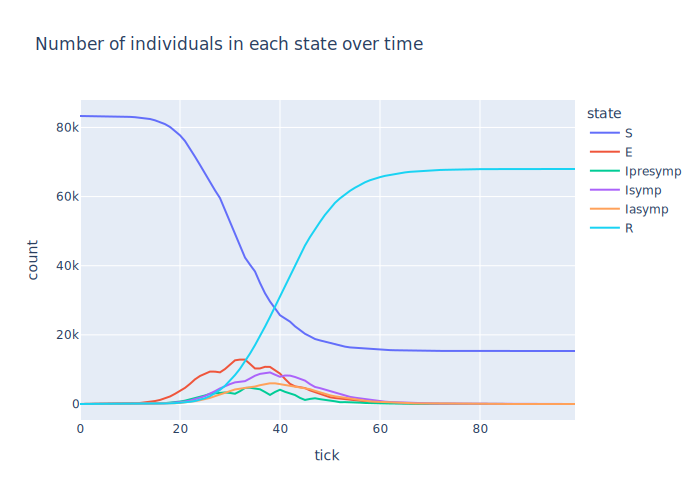

In [20]:
states = summary.columns
states.remove("tick")

title = "Number of individuals in each state over time"
pdf = summary.melt(id_vars="tick", value_vars=states, variable_name="state", value_name="count")
px.line(pdf, x="tick", y="count", color="state", title=title)

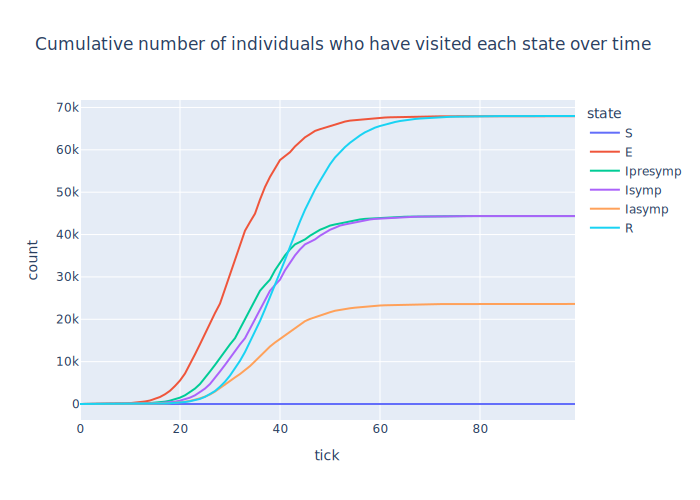

In [21]:
num_ticks = simulator.num_ticks(output_file)
state_tick_cum_counts = simulator.compute_state_tick_unique_counts(transitions, num_ticks)

states = state_tick_cum_counts.columns
states.remove("tick")

state_tick_cum_counts = state_tick_cum_counts.with_columns(
    *[pl.col(state).cum_sum() for state in states]
)

title = "Cumulative number of individuals who have visited each state over time"
pdf = state_tick_cum_counts.melt(id_vars="tick", value_vars=states, variable_name="state", value_name="count")
px.line(pdf, x="tick", y="count", color="state", title=title)